In [1]:
from PIL import Image
import requests
import torch

imports modules for registration

In [2]:
from common.registry import registry
from processors import *
from models import *

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

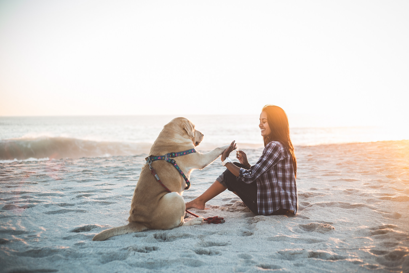

In [4]:
def load_demo_image():
    img_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/demo.jpg' 
    raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   

    w,h = raw_image.size
    display(raw_image.resize((w//5,h//5)))

    return raw_image
image = load_demo_image()

# 1. create image processors with arguments.
vis_processor = BlipCOCORetImageEval(image_size=384)

# 2. Create default image processors from empty config.
# print(registry.get_processor_class("blip_coco_ret_vis_eval"))
# vis_processor = registry.get_processor_class("blip_coco_ret_vis_eval") \
#                         .build_processor(OmegaConf.create())

# 3. Create image processors with customized configuration.
# config = OmegaConf.create({"image_size": 384})
# vis_processor = registry.get_processor_class("blip_coco_ret_vis_eval") \
#                         .build_processor(cfg=config)


# No text_processor is required for caption inference.
# text_processor = registry.get_processor_class("blip_coco_ret_text") \
#                         .build_processor()

samples = {'vis_data': vis_processor(image).unsqueeze(0).to(device)}

models

In [5]:
# (1) build model with default architecture (base)
# model = registry.get_model_class("blip_enc_dec") \
#                 .build_default_model()

# (2) build model with specific architecture (base)
model = registry.get_model_class("blip_enc_dec") \
                .build_default_model(model_type="large")
# (2a) To add a new model type
#    - write a model configuration file
#         e.g. configs/models/blip_enc_dec_base.yaml
#    - add the configuration filepath to model default
#         e.g. blip_model.py, line 33

# (3) build model with customized encoder decoder
# (3a) build modules from OmegaConfig instance.
# from models.med import XBertLMHeadDecoder
# from omegaconf import OmegaConf
# config = OmegaConf.create({"med_config_path": "configs/models/med_config.json"})
# decoder = XBertLMHeadDecoder.build_model(cfg=config)
# # (3b) build modules by __init__()
# from models.vit import VisionTransformerEncoder
# encoder = VisionTransformerEncoder(img_size=384)

# (3c) Expecting good captions
# prompt = "a picture of "
# Expecting less satisfactory captions.
# prompt = ""

# model = BlipEncoderDecoder(encoder=encoder, decoder=decoder, prompt=prompt)

# print("loading pretrain weights.")
# url_or_filename = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_caption_capfilt_large.pth"
# # url_or_filename = "https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth"

model, msg = BlipEncoderDecoder.load_from_pretrained(model, url_or_filename)


loading pretrain weights.
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_caption_capfilt_large.pth


In [6]:
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(samples, use_nucleus_sampling=False, num_beams=3, max_length=20, min_length=5) 
    print('beam: '+caption[0])
    # nucleus sampling
    caption = model.generate(samples, use_nucleus_sampling=True, top_p=0.9, max_length=20, min_length=5) 
    print('nucl: '+caption[0])

beam: the woman is petting the dog on the beach by the water
nucl: there is a woman sitting on the beach with her dog giving something
